# July 17, 2023: Synthetic dynamical systems, 2D: SINDy discovery

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
import pandas as pd
import pysindy as ps
import sklearn as skl
from scipy.spatial.distance import pdist, cdist, squareform, cosine
from scipy import stats, integrate
import tvb
import networkx as nx
import copy
import matlab.engine
from itertools import product
from tqdm import tqdm
from netrd.distance import ResistancePerturbation, PortraitDivergence, GraphDiffusion, DMeasure

sys.path.append("/usr/local/MATLAB/R2022b/bin/matlab")

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/apr23"
bdmodels_dir = f"{proj_dir}/helpers/bdmodels"
networks_dir = f"{proj_dir}/helpers/networks"
results_dir = f"{proj_dir}/results"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# folders
sys.path.insert(0, proj_dir)
import helpers.functions.network_utils as nw_utils
import helpers.functions.plotting_utils as plot_utils
import helpers.functions.time_series_simulation_utils as ts_sim_utils
import helpers.functions.fc_utils as fc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

## van der Pol data

### data

In [3]:
args.num_rois = 1
network = 1 - np.eye(args.num_rois)
# network[0, 1] = 0.0
# network[1, 0] = 0.0
network

array([[0.]])

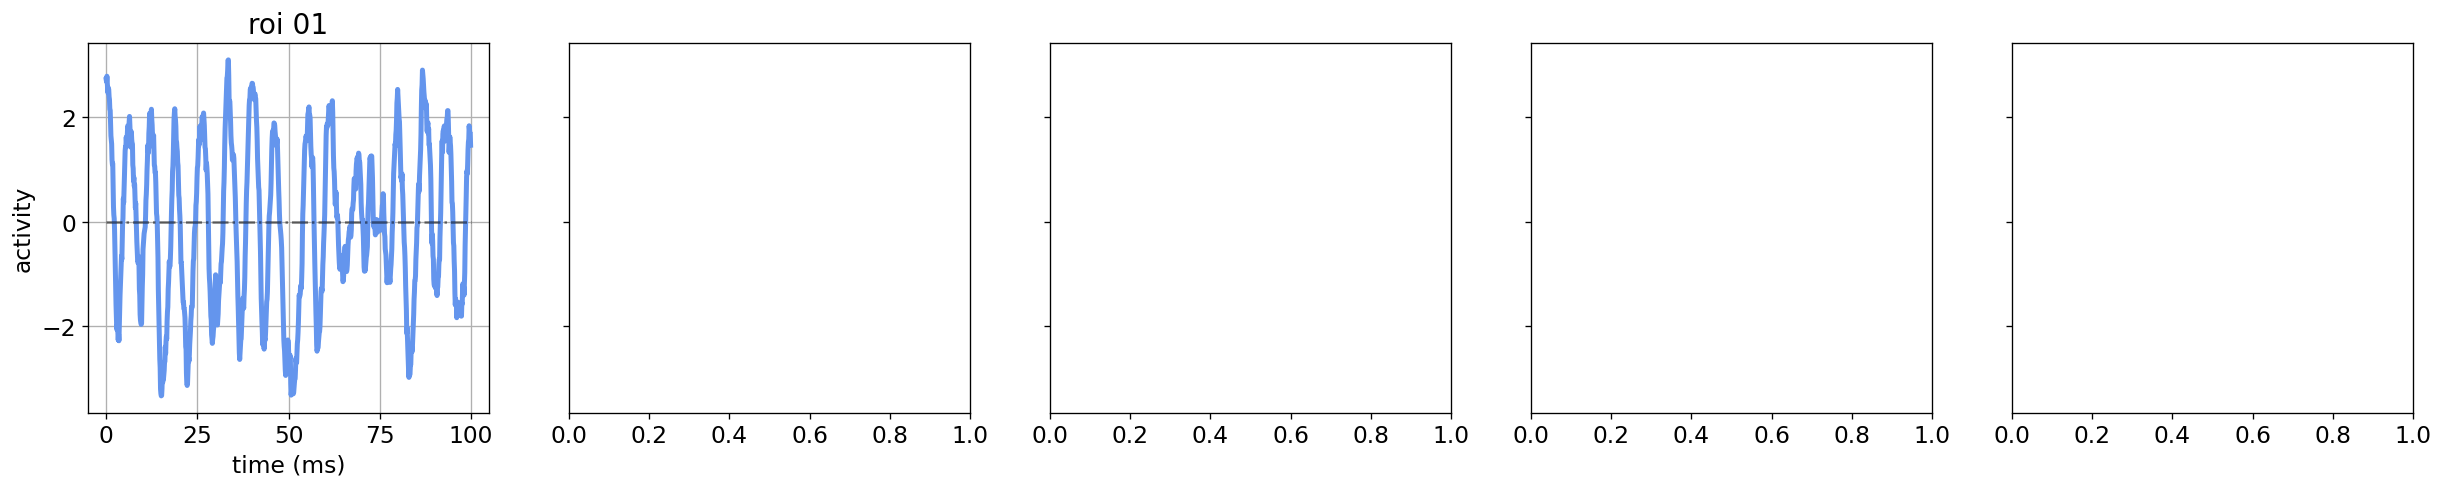

In [4]:
args.dt = 0.1
args.time_end = 100
args.time_span = [0, args.time_end]
args.time = np.arange(0, args.time_end, args.dt)


stimulus = np.array([[1.0]]) #np.array([[1.0], [0.0]])

in_dict = {}
in_dict['a'] = matlab.double(np.array([[0.5]]))
in_dict['b'] = 0.0
in_dict['c'] = 0.0
in_dict['Iamp'] = 1.0
in_dict['tau'] = 10.0
in_dict['T'] = 30.0
in_dict['tspan'] = matlab.double(args.time_span) 
in_dict['teval'] = matlab.double(args.time)
in_dict['s'] = matlab.double(stimulus)
in_dict['sigma'] = 0.5
in_dict['x_init'] = matlab.double(5*np.random.rand(2*args.num_rois))

eng = matlab.engine.start_matlab()
model_path = f"{bdmodels_dir}"
model = eng.simulate_vanderPol_oscillators_SDE_B

in_dict['W'] = network
in_dict['randn'] = np.random.normal(
    loc=0.0, 
    scale=1.0, 
    size=(2*args.num_rois, args.time.size),
)

out_dict = ts_sim_utils.simulate(eng, model_path, model, in_dict)
args.subplot_layout = 'row-col'
plot_utils.plot_roi_time_series(
    args, 
    out_dict,
)

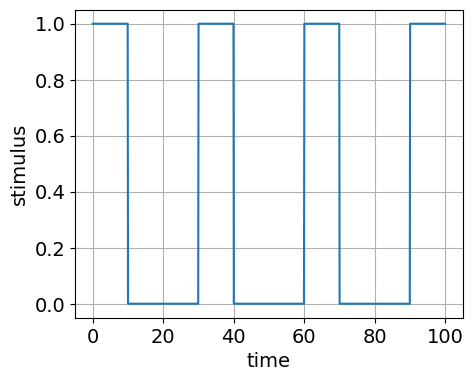

In [5]:
def u_fun(t, tau=10.0, T=30.0, Iamp=1.0,):
    return Iamp * (np.mod(t, T) < tau)

x_train = np.hstack(
    (out_dict['x'], out_dict['w'])
)
u_train = u_fun(args.time, in_dict['tau'])

fig, axs = plt.subplots(1, 1, figsize=(5,4))
ax = axs
ax.plot(args.time, u_train)
ax.set_xlabel('time')
ax.set_ylabel('stimulus')
ax.grid(True)

### SINDy

In [6]:
## SINDy discovery
# fit
poly_order = 5
threshold = 0.1

optimizer = ps.STLSQ(threshold=threshold)
# optimizer = ps.SR3()

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    differentiation_method=ps.FiniteDifference(axis=-2),
    feature_names=['x', 'w', 'u'],
)
model.fit(
    x=x_train, 
    t=args.dt, 
    u=u_train, 
    multiple_trajectories=False,
    library_ensemble=True,
)
model.print()

# simulate
x_sim = model.simulate(
    x0=x_train[0],
    t=args.time,
    u=u_fun(args.time),
)

# predicted vs empirical time series: 
# 1.0 (perfect predictions) or 0.0 (imperfect predictions)
r2 = skl.metrics.r2_score(x_train[1:], x_sim)
print(f"R2: {r2}")

(x)' = 1.032 w
(w)' = -0.988 x + 0.576 w + -0.454 x^2 w
R2: -1.279549782642828


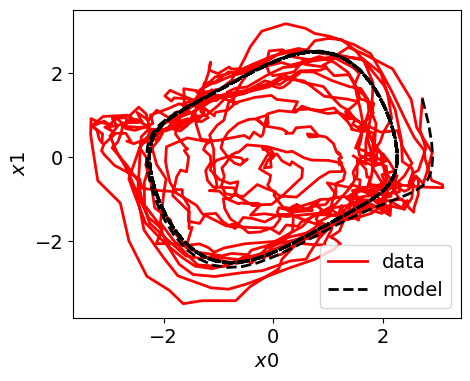

In [7]:
if x_sim.shape[-1] == 1:
    plot_kws = dict(linewidth=2)

    fig, axs = plt.subplots(1, 1, figsize=(5, 4))
    axs.plot(args.time, x_train[:, 0], "r", label="data", **plot_kws)
    axs.plot(args.time[1:], x_sim[:, 0], "k--", label="model", **plot_kws)
    axs.legend()
    axs.set(xlabel="time", ylabel="$x$")
    fig.show()
elif x_sim.shape[-1] == 2:
    plot_kws = dict(linewidth=2)

    fig, axs = plt.subplots(1, 1, figsize=(5, 4))
    axs.plot(x_train[:, 0], x_train[:, 1], "r", label="data", **plot_kws)
    axs.plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
    axs.legend()
    axs.set(xlabel="$x0$", ylabel="$x1$")
    fig.show()

## Kuramoto 

### data

In [8]:
# args.num_rois = 1
# network = 1 - np.eye(args.num_rois)
# # network[0, 1] = 0.0
# # network[1, 0] = 0.0
# network

In [9]:
# args.dt = 0.1
# args.time_end = 100
# args.time_span = [0, args.time_end]
# args.time = np.arange(0, args.time_end, args.dt)


# stimulus = np.array([[1.0]]) #np.array([[1.0], [0.0]])

# in_dict = {}
# in_dict['a'] = matlab.double(np.array([[0.5]])) #matlab.double(np.array([[0.5], [0.5]]))
# in_dict['b'] = 0.0
# in_dict['c'] = 0.0
# in_dict['Iamp'] = 1.0
# in_dict['tau'] = 0.0
# in_dict['T'] = 30.0
# in_dict['tspan'] = matlab.double(args.time_span) 
# in_dict['teval'] = matlab.double(args.time)
# in_dict['s'] = matlab.double(stimulus)
# in_dict['sigma'] = 0.5
# in_dict['x_init'] = matlab.double(3*np.random.rand(2*args.num_rois))

# eng = matlab.engine.start_matlab()
# model_path = f"{bdmodels_dir}"
# model = eng.simulate_vanderPol_oscillators_SDE_B

# in_dict['W'] = network
# in_dict['randn'] = np.random.normal(
#     loc=0.0, 
#     scale=1.0, 
#     size=(2*args.num_rois, args.time.size),
# )

# out_dict = ts_sim_utils.simulate(eng, model_path, model, in_dict)
# args.subplot_layout = 'row-col'
# plot_utils.plot_roi_time_series(
#     args, 
#     out_dict,
# )

In [10]:
# def u_fun(t, tau=0.0, T=30.0, Iamp=1.0,):
#     return Iamp * (np.mod(t, T) < tau)

# x_train = np.hstack(
#     (out_dict['x'], out_dict['w'])
# )

# u_train = u_fun(args.time)
# # fig, axs = plt.subplots(1, 1, figsize=(5,4))
# # ax = axs
# # ax.plot(args.time, u_train)
# # ax.set_xlabel('time')
# # ax.set_ylabel('stimulus')
# # ax.grid(True)

In [11]:
# ## SINDy discovery
# # fit
# poly_order = 5
# threshold = 0.1

# optimizer = ps.STLSQ(threshold=threshold)
# # optimizer = ps.SR3()

# model = ps.SINDy(
#     optimizer=ps.STLSQ(threshold=threshold),
#     feature_library=ps.PolynomialLibrary(degree=poly_order),
#     differentiation_method=ps.FiniteDifference(axis=-2),
#     feature_names=['x', 'w', 'u'],
# )
# model.fit(
#     x=x_train, 
#     t=args.dt, 
#     u=u_fun(args.time), 
#     multiple_trajectories=False,
#     library_ensemble=True,
# )
# model.print()

# # simulate
# x_sim = model.simulate(
#     x0=x_train[0],
#     t=args.time,
#     u=u_fun(args.time),
# )

# # predicted vs empirical time series: 
# # 1.0 (perfect predictions) or 0.0 (imperfect predictions)
# r2 = skl.metrics.r2_score(x_train[1:], x_sim)
# print(f"R2: {r2}")

In [12]:
# if x_sim.shape[-1] == 1:
#     plot_kws = dict(linewidth=2)

#     fig, axs = plt.subplots(1, 1, figsize=(5, 4))
#     axs.plot(args.time, x_train[:, 0], "r", label="data", **plot_kws)
#     axs.plot(args.time[1:], x_sim[:, 0], "k--", label="model", **plot_kws)
#     axs.legend()
#     axs.set(xlabel="time", ylabel="$x$")
#     fig.show()
# elif x_sim.shape[-1] == 2:
#     plot_kws = dict(linewidth=2)

#     fig, axs = plt.subplots(1, 1, figsize=(5, 4))
#     axs.plot(x_train[:, 0], x_train[:, 1], "r", label="data", **plot_kws)
#     axs.plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
#     axs.legend()
#     axs.set(xlabel="$x0$", ylabel="$x1$")
#     fig.show()